In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

Executed query and closed connection.


In [3]:
execRangeQuery(param_dic,('2014-01-08','2014-01-09'))[0][0]

Executed query and closed connection.


538

In [4]:
query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.


In [5]:
#counts

In [6]:
T = 1794
print(np.log2(1794))
print(int(np.ceil(np.log2(1794))))
print(2**np.ceil(np.log2(1794)))


10.80896417491926
11
2048.0


In [7]:
def get_index(date_idx, n_layers):
    """Calculates the path of index in full binary string

    Parameters:
    date_idx (int): The node in the bouttom layer we want to calculate a path to. 
    The bottom layer has index from 0 to 2**h-1
    n_layers (int): The height of the full binary tree. 

    Returns:
    list: of index in the path from the starting from the bottom and going up

    """
    idx = []
    for i in np.arange(0,n_layers):
        if i == 0:
            idx.append(int(date_idx))
        else:
            idx.append(int(idx[i-1]//2))
    idx.append(0)
    return idx

In [8]:
T = len(dates)
print(T)
T = 2**np.ceil(np.log2(T))
print(T)
n_layers = int(np.log2(T))
print(f'n_layers = {n_layers}')
print(get_index(2**np.ceil(np.log2(T))-1,n_layers))

1794
2048.0
n_layers = 11
[2047, 1023, 511, 255, 127, 63, 31, 15, 7, 3, 1, 0]


In [9]:
print(get_index(0,1))
print(get_index(0,2))
print(get_index(0,3))
print(get_index(12,4))

[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[12, 6, 3, 1, 0]


In [10]:
print(get_index(0,n_layers))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
class con_obs:
    
    def __init__(self, T, epsilon, dates, counts):
        """Setup of the datastructere

        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        # We need the stream to be a power of 2
        self.T = int(2**np.ceil(np.log2(T)))
        self.epsilon = epsilon
        self.zeta = (np.log2(T))/epsilon
        self.dates = dates
        # The height of the "Binary tree"
        self.n_layers = int(np.log2(self.T))
        
        # Get laplace for each node
        self.laplaces = self.__init_laplace()
        
        values = np.arange(0,len(dates))
        zip_iterator = zip(dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.real_counts = counts
        
        self.noise_counts = self.__process(self.real_counts)
        
        
    def __init_laplace(self):
        """
        returns: list of arrays with the correct size of laplaces variabels.
        """
        laplaces = []
        for i in np.arange(0,self.n_layers+1):
            rvs = laplace(scale=self.zeta).rvs(int(2**np.ceil(i)))
            laplaces.append(rvs)
        
        return laplaces
    
    
    def __process(self, counts):
        noise_counts = np.zeros(len(dates))
        for idx, date_count in enumerate(counts):
            indices = self.get_index(idx,self.n_layers)
            indices.reverse()
            laplace_sum = 0.0
            for laplace_idx, laplace_row in enumerate(self.laplaces):
                laplace_sum = laplace_sum + laplace_row[indices[laplace_idx]]
            noise_counts[idx] = date_count  +  noise_counts[idx-1] + laplace_sum
        return noise_counts
    
    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        if (len(dates) < 2):
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            #print(date_obj_0)
            #print(type(date_obj_0))
            idx = self.idx_dict[date_obj_0]
            #Index is not 0
            if idx:
                return self.noise_counts[idx] - self.noise_counts[idx-1]            
            else:
                return self.noise_counts[idx]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]
            
            #idx_0 is not 0
            if idx_0:
                return self.noise_counts[idx_1] - self.noise_counts[idx_0-1]            
            else:
                return self.noise_counts[idx_1]
            
        
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.real_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.real_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_

        
        

T = len(dates)
epsilon = 0.7
c_o = con_obs(T, epsilon, dates, counts)

In [12]:
print(c_o.answer(('2014-01-08','2014-01-09')))
print(c_o.real_answer(('2014-01-08','2014-01-09')))
print(execRangeQuery(param_dic,dates)[0][0])

print(c_o.answer(('2014-01-20',)))
print(c_o.real_answer(('2014-01-20',)))

print(c_o.answer(('2014-01-02','2014-01-05')))
print(c_o.real_answer(('2014-01-02','2014-01-05')))



316.8817332955733
538
Executed query and closed connection.
357
255.7988438512516
315
426.6381625021445
488


In [13]:
def relative_error_percentage(x_approx, x_true):
    # | (V - Vapprox) / V | x 100% 
    return np.abs((x_true-x_approx)/x_true)*100


def relative_error(x_approx, x_true):
    # | 1 - (Vapprox / V) | 
    return np.abs(1-(x_approx/x_true))
 

In [14]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])

In [15]:
error_dicts = {}

for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-08','2014-01-09')
    answears = np.zeros(number_of_queries)
    corret_answear = execRangeQuery(param_dic,range_dates)[0][0]
    for i in range(0,number_of_queries):
        c_o = con_obs(T, epsilon, dates, counts)
        answears[i] = c_o.answer(('2014-01-08','2014-01-09'))
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    vfunc = np.vectorize(relative_error)
    rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'rel': np.mean(rel_erorrs)}



2.0
Executed query and closed connection.
1.4
Executed query and closed connection.
1.2
Executed query and closed connection.
1.0
Executed query and closed connection.
0.8
Executed query and closed connection.
0.7
Executed query and closed connection.
0.5
Executed query and closed connection.
0.4
Executed query and closed connection.
0.3
Executed query and closed connection.


In [17]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
rel_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    rel_errors[num] = item[1]['rel']

In [18]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,rel_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
rel_labels = np.full(rel_errors.size, 'rel errors')

labels_stack = np.vstack((min_labels,mse_labels,max_labels,rel_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()


In [19]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('con_obs_seaborn_plotting_data.csv',index=False)

In [20]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'rel_errors':rel_errors})
all_data.to_csv('con_obs_plotting_data.csv',index=False)

In [21]:
sns.set()

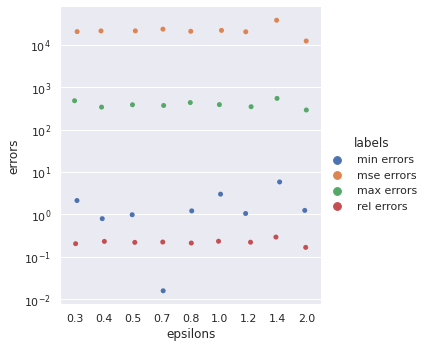

In [22]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("con_AllErrors.png")


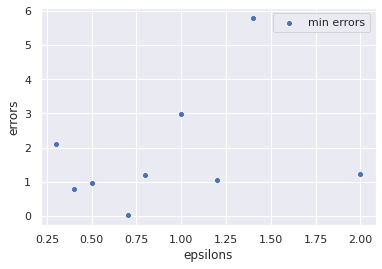

In [23]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 

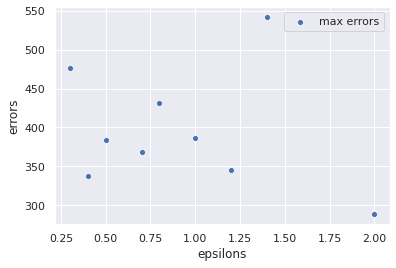

In [24]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'max errors'], x ='epsilons', y ='errors')
plt.legend(labels=['max errors'])
sns_plot.get_figure().savefig('con_max_error.png') 

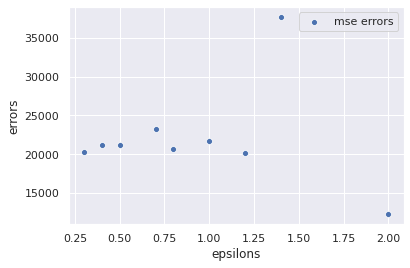

In [25]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'mse errors'], x ='epsilons', y ='errors')
plt.legend(labels=['mse errors'])
sns_plot.get_figure().savefig('con_mse_error.png') 

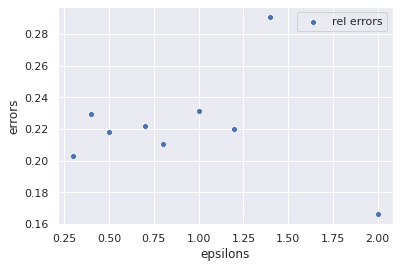

In [26]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'rel errors'], x ='epsilons', y ='errors')
plt.legend(labels=['rel errors'])
sns_plot.get_figure().savefig('con_rel_error.png') 